## **README**
  
[GVAE] H. Hosoya, “Group-based Learning of Disentangled Representations with Generalizability for Novel Contents,” in Proceedings of the Twenty-Eighth International Joint Conference on Artificial Intelligence, Macao, China, 2019, pp. 2506–2513, doi: 10.24963/ijcai.2019/348.

 
[MLVAE] D. Bouchacourt, R. Tomioka, and S. Nowozin, “Multi-Level Variational Autoencoder: Learning Disentangled Representations from Grouped Observations,” arXiv:1705.08841 [cs, stat], May 2017, Accessed: Feb. 19, 2021. [Online]. Available: http://arxiv.org/abs/1705.08841.
  

In [1]:
# -*- coding: utf-8 -*-
from IPython import display

import os, sys, time, glob, io, pprint, re, shutil
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
import h5py
import pandas as pd
from datetime import datetime

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
tfkltd = tf.keras.layers.TimeDistributed
from tensorflow.keras.utils import to_categorical

from absl import app, flags

if not sys.version_info[0]==3:
    sys.exit("Python 3 required")

""" specify available GPUs """
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"

""" limit GPU memory growth """
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # currently memory growth needs to be same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs\n\n")
    except RuntimeError as e:
        # memory growth must be set before GPUs have been initialized
        print(e)
        
""" clear tensorflow session """
tfk.backend.clear_session()


4 Physical GPUs 4 Logical GPUs




In [2]:
strategy = tf.distribute.MirroredStrategy()
print('num devices = %d'%strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
num devices = 4


### Create MNIST instances with common digit but varying 5x5 masks.

In [3]:
NUM_INSTANCES = 21 # number of instances in a bag
NUM_CLASS = 10     # mnist has 10 classes

(trn_images, trn_labels), (tst_images, tst_labels) = tfk.datasets.mnist.load_data()

def rescale_and_flatten_images(images):
    images = images.reshape((images.shape[0], 28*28)) / 255.
    return images.astype('float32')
#     return np.where(images > .5, 1.0, 0.0).astype('float32')

trn_images = rescale_and_flatten_images(trn_images)
tst_images = rescale_and_flatten_images(tst_images)

print(trn_images.shape)
print(tst_images.shape)

(60000, 784)
(10000, 784)


In [4]:
BUFFER_SIZE = trn_images.shape[0]
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

NUM_TRAIN=trn_images.shape[0]
MASK_SIZE=10

class MaskedMNISTDataset(tf.data.Dataset):
    def _generator():
        """ Yields a single datapoint which consists of the tuple

            data_replicate = (R[0]data, ..., R[nreplicate]data)
            shifts = 
        """
        for ii in range(NUM_TRAIN):
            img = trn_images[ii,:] # [data_dim]
            img = np.expand_dims(img, axis=0) #[1, data_dim]
            img_instances = np.repeat(img, NUM_INSTANCES, axis=0) #[instances, data_dim]
            
            for kk in range(NUM_INSTANCES):
                tmp = img_instances[kk,:].reshape(28,28)

                mask = np.ones((28,28))
                xx = np.random.randint(28-MASK_SIZE)
                yy = np.random.randint(28-MASK_SIZE)
                
                tmp[xx:(xx+MASK_SIZE), yy:(yy+MASK_SIZE)] = 1.
                img_instances[kk,:] = tmp.flatten()
            
            bagged_masked_img = img_instances
            
#             mask_instances = np.zeros(img_instances.shape)
#             for kk in range(NUM_INSTANCES):
#                 mask = np.ones((28,28))
#                 xx = np.random.randint(28-MASK_SIZE)
#                 yy = np.random.randint(28-MASK_SIZE)
                
#                 mask[xx:(xx+MASK_SIZE), yy:(yy+MASK_SIZE)] = 0.
#                 mask_instances[kk,:] = mask.flatten()
            
#             bagged_masked_img = img_instances*mask_instances
            
            yield bagged_masked_img.astype('float32')
               
    def __new__(self):
        return tf.data.Dataset.from_generator(
            self._generator,
            output_types = (tf.float32),
            output_shapes = (tf.TensorShape([NUM_INSTANCES, 28*28])),            
        )
    
trn_dataset = MaskedMNISTDataset().prefetch(tf.data.experimental.AUTOTUNE)
trn_dataset = trn_dataset.shuffle(NUM_TRAIN)
trn_dataset = trn_dataset.batch(GLOBAL_BATCH_SIZE)

# distributed dataset
trn_dist_dataset = strategy.experimental_distribute_dataset(trn_dataset)

### Define GVAE Model

In [5]:
""" Custom Layers """
class StyleEncoder(tfkl.Layer):
    """ Responsible for encoding the style of each instance.
    
    Maps [?, instances, data_dim] -> [?, instances, sty_dim] (for mean and log-variance)
    """
    def __init__(self, style_dim, mask_rate, name='style_encoder', **kwargs):
        """ initialization """
        super().__init__(name, **kwargs)
        
        self.mask_rate = mask_rate # fraction of entries to mask to zero
        
        """ define dimensions """
        self.style_dim = style_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(style_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(style_dim)
                    ],
                    name="z_mean",
                )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, style_dim]
        common = self.enc_per_instance(inputs)
        
        z_mean = self.enc_mean(common) # [?*instances, style_dim]
        
        # reshape back to [?, instances, style_dim]
        z_mean = tfkl.Reshape((ninstances, self.style_dim))(z_mean)
        
        # add Dropout mask
        z_mean = tfkl.Dropout(self.mask_rate)(z_mean) # Dropout automatically scales by 1/(1-p)
        
        return z_mean
    
class ContentEncoder(tfkl.Layer):
    """ Responsible for encoding the content common to each instance.
    
    For GVAE the content encoder N(z|x1,...xk) has the parametric form
    of N( \avg \mu(xi), \avg s(xi), i.e. averaging a common encoder across instances.
    
    Maps [?, instances, data_dim] -> [?, 1, content_dim] (for mean and log-variance)
    """
    def __init__(self, content_dim, name='style_encoder', **kwargs):
        """ initialization """
        super().__init__(name, **kwargs)
        
        """ define dimensions """
        self.content_dim = content_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(content_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(content_dim)
                    ],
                    name="z_mean",
                )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, content_dim]
        common = self.enc_per_instance(inputs)
        
        z_mean = self.enc_mean(common) # [?*instances, content_dim]
        
        # reshape back to [?, instances, content_dim]
        z_mean = tfkl.Reshape((ninstances, self.content_dim))(z_mean)
        
        # compute average to [?, content_dim]
        z_mean = tfkl.GlobalAveragePooling1D()(z_mean)
        
        # [?, content_dim] -> [?, 1, content_dim]
        z_mean = tfkl.Reshape((1, self.content_dim))(z_mean)
        
        return z_mean

class Decoder(tfkl.Layer):
    """ Decodes each pair of (z_content, z_instance)
    
    The number of instances is automatically inferred at runtime.
    
    Maps [?, instances, latent_dim] -> [?, instances, data_dim]
    """
    def __init__(self, data_dim,
            name='decoder', **kwargs):
        super().__init__(name, **kwargs)
        
        self.data_dim = data_dim
                
        self.dec_per_instance = tfk.Sequential(
            [   tfkl.Dense(256),
                tfkl.LeakyReLU(),
                tfkl.Dense(512),
                tfkl.LeakyReLU(),
                tfkl.Dense(data_dim, activation='sigmoid'),
            ],
            name="dec_per_instance",        
        )

    def call(self, z):
        # infer number of instances [?, instances, latent_dim]
        ninstances = z.shape[1]
        latent_dim = z.shape[2]
        
        # reshape instances to sample axis : [?*instances, latent_dim]
        z = tfkl.Reshape((-1, latent_dim))(z)
        # apply decoding to each instance : [?*instances, data_dim]
        x_mean = self.dec_per_instance(z)
        # collect instances : [?, instances, data_dim]
        x_mean = tfkl.Reshape((ninstances, self.data_dim))(x_mean)
        
        return x_mean
    
class SYMAE(tfk.Model):
    """ Grouped Variational Auto-Encoder
    
    [Input]
        X ~ [?, instances, data_dim]
    """
    def __init__(self, data_dim, style_dim, content_dim, mask_rate,
            nsamp=1, name='GVAE', dec_var_model ='trainable', **kwargs):
        """ initialize """
        super().__init__(name=name, **kwargs)

        self.mask_rate = mask_rate
        
        """ define dimensions """
        self.data_dim = data_dim
        self.style_dim = style_dim
        self.content_dim = content_dim
        latent_dim = style_dim + content_dim
        self.latent_dim = style_dim + content_dim
                        
        """ build encoder & decoder graphs """
        self.style_encoder = StyleEncoder(style_dim, mask_rate)
        self.content_encoder = ContentEncoder(content_dim)
        self.decoder = Decoder(data_dim)
        
    def call(self, inputs):
        # input = [?, instances, data_dim]
        X = inputs
        ninstances = X.shape[1]
        
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
                
        # concatenate
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode
        dec_mean = self.decoder(z)

        """ compute ELBO loss """
        
        # squared error per example
        se = tf.square(X - dec_mean) # [?, instances, data_dim]
        se_per_instance = tf.reduce_sum(se, axis=-1) # [?, instances]
        se_per_ex = tf.reduce_sum(se_per_instance, axis=-1) #[?, ]
                
        return se_per_ex, dec_mean

    def encode_decode(self, inputs):
        """ Apply VAE deterministically: xhat = dec(enc(x))
        """
        X = inputs
        ninstances = X.shape[1]
                
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
   
        # concatenate:  [?, instances, latent_dim]
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode: [?, instances, data_dim]
        dec_mean = self.decoder(z)

        return dec_mean
    
    def content_encode(self, X):        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean = self.content_encoder(X)
        return cnt_mean
    
    def style_encode(self, X):         
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        return sty_mean
    
    def style_decode(self, cnt_mean, sty_mean):
        ninstances = sty_mean.shape[1]
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances)(cnt_mean)
   
        # concatenate:  [?, instances, latent_dim]
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode: [?, instances, data_dim]
        dec_mean = self.decoder(z)
        
        return dec_mean
        
    

### Optimization

In [6]:
with strategy.scope():
    # define model
    style_dim = 20
    content_dim = 20
    data_dim = 28*28
    mask_rate = 0.9
    ninstances = NUM_INSTANCES
    
    symae = SYMAE(data_dim, style_dim, content_dim, mask_rate)
    
    # setup exponential schedular
    initial_learning_rate = 2e-4
#     initial_learning_rate = 1e-3
    lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps=2000,
                decay_rate=0.96,
                staircase=True)

    # opt = tf.optimizers.Adam(learning_rate=5e-4)
    opt = tf.optimizers.Adam(learning_rate=lr_schedule)
    
    # instantiante model again inside strategy scope   
    trn_loss_metric = tfk.metrics.Mean()
    trn_mse_metric = tfk.metrics.Mean()
    trn_sty_KL_metric = tfk.metrics.Mean()
    trn_cnt_KL_metric = tfk.metrics.Mean()

@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # call model: returns losses per each example, i.e. shape [?,]
        mse_per_ex, _ = symae(inputs, training=True)

        # compute average loss using batch size
        loss = tf.nn.compute_average_loss(mse_per_ex, global_batch_size=GLOBAL_BATCH_SIZE)
        
    # track metrics
    trn_loss_metric(mse_per_ex)
    
    # apply gradients
    grads = tape.gradient(loss, symae.trainable_weights)
    opt.apply_gradients(zip(grads, symae.trainable_weights))
    
    return loss

# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    return 


Start of epoch 0
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/repli

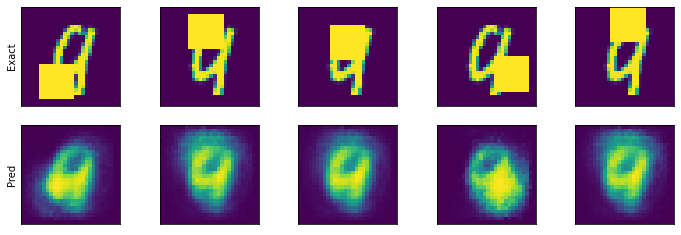

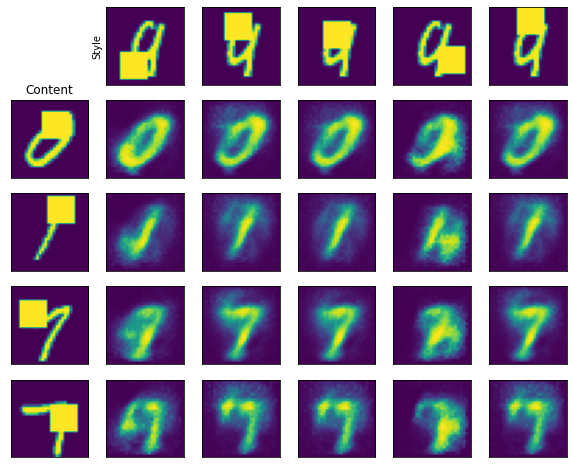

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
	mean loss    = 1576.423
epoch = 59.86s
Start of epoch 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
	mean loss    = 1191.103
epoch = 44.95s
Start of epoch 2
	mean loss    = 1074.833
epoch = 42.97s
Start of epoch 3
	mean loss    = 1015.954
epoch = 44.82s
Start of epoch 4
	mean loss    = 979.122
epoch = 44.54s
Start of epoch 5
=== TRN ===


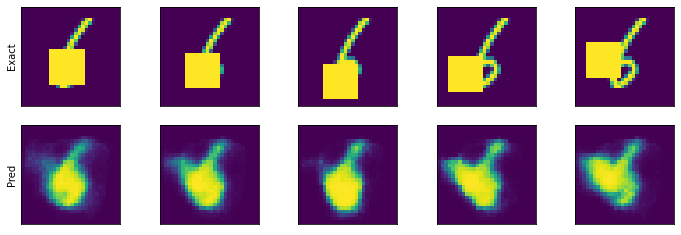

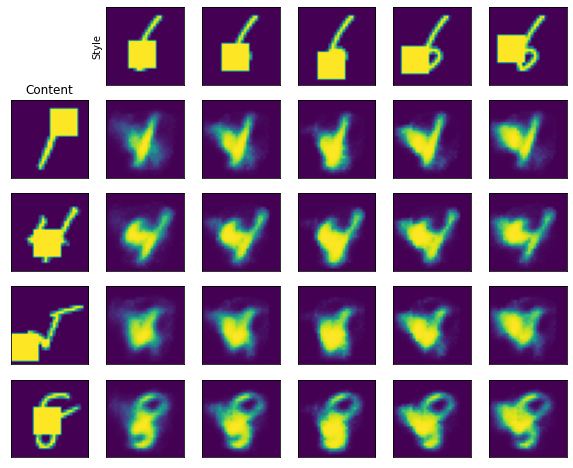

	mean loss    = 955.980
epoch = 45.77s
Start of epoch 6
	mean loss    = 936.097
epoch = 44.22s
Start of epoch 7
	mean loss    = 918.308
epoch = 44.39s
Start of epoch 8
	mean loss    = 902.853
epoch = 44.30s
Start of epoch 9
	mean loss    = 888.802
epoch = 44.85s
Start of epoch 10
=== TRN ===


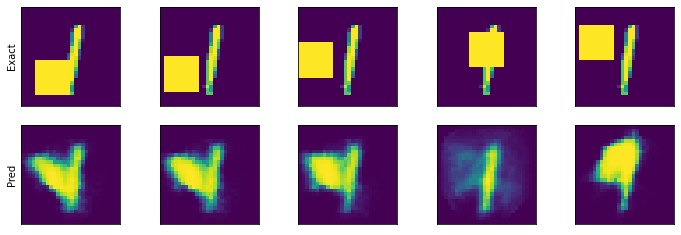

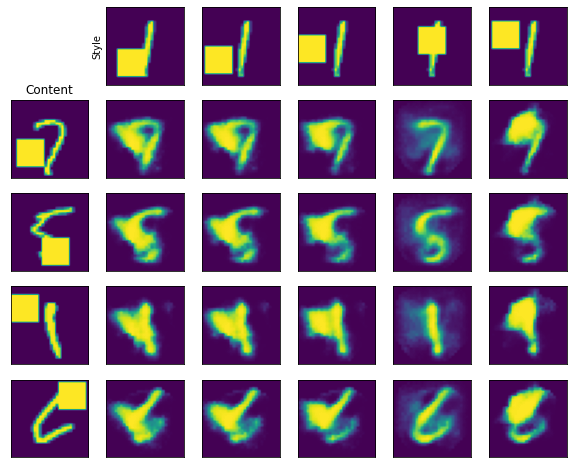

	mean loss    = 877.862
epoch = 45.79s
Start of epoch 11
	mean loss    = 866.441
epoch = 45.15s
Start of epoch 12
	mean loss    = 855.837
epoch = 44.78s
Start of epoch 13
	mean loss    = 846.855
epoch = 44.61s
Start of epoch 14
	mean loss    = 838.506
epoch = 43.89s
Start of epoch 15
=== TRN ===


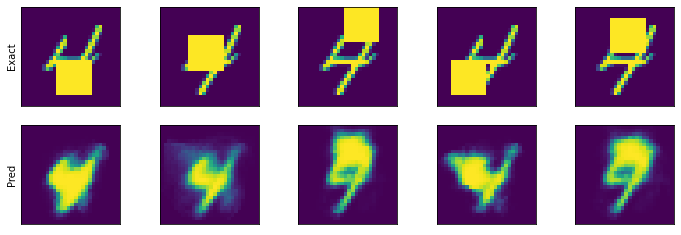

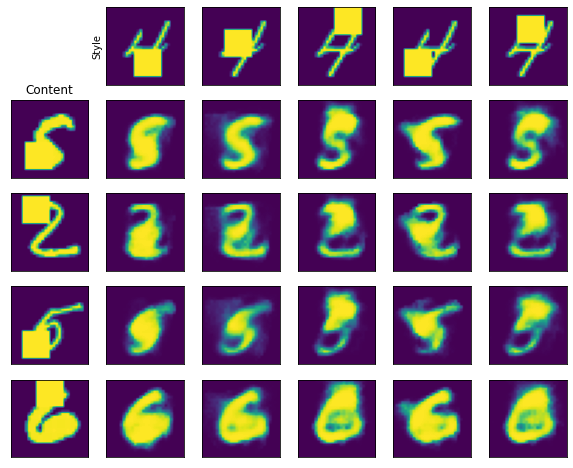

	mean loss    = 830.351
epoch = 45.13s
Start of epoch 16
	mean loss    = 823.476
epoch = 44.44s
Start of epoch 17
	mean loss    = 814.363
epoch = 44.45s
Start of epoch 18
	mean loss    = 806.598
epoch = 44.17s
Start of epoch 19
	mean loss    = 801.769
epoch = 44.09s
Start of epoch 20
=== TRN ===


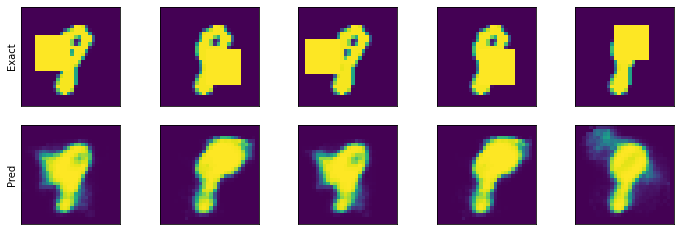

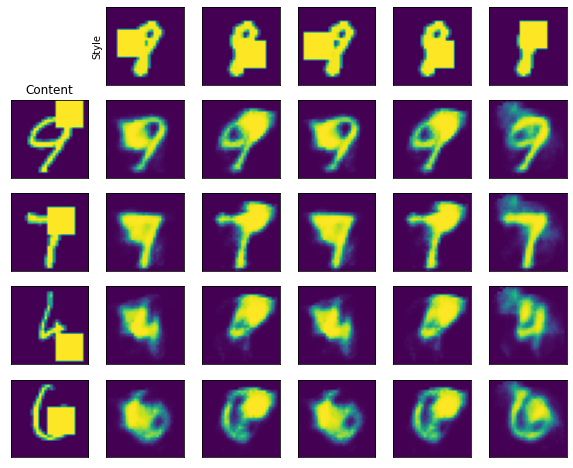

	mean loss    = 794.985
epoch = 45.65s
Start of epoch 21
	mean loss    = 788.851
epoch = 45.10s
Start of epoch 22
	mean loss    = 784.481
epoch = 43.70s
Start of epoch 23
	mean loss    = 778.318
epoch = 44.08s
Start of epoch 24
	mean loss    = 773.944
epoch = 43.96s
Start of epoch 25
=== TRN ===


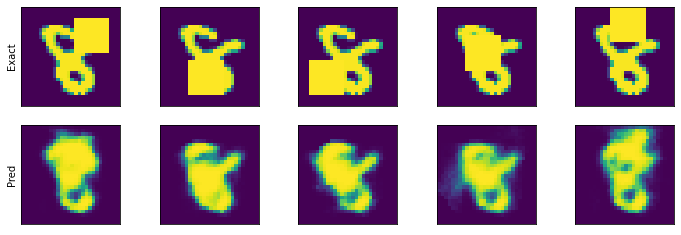

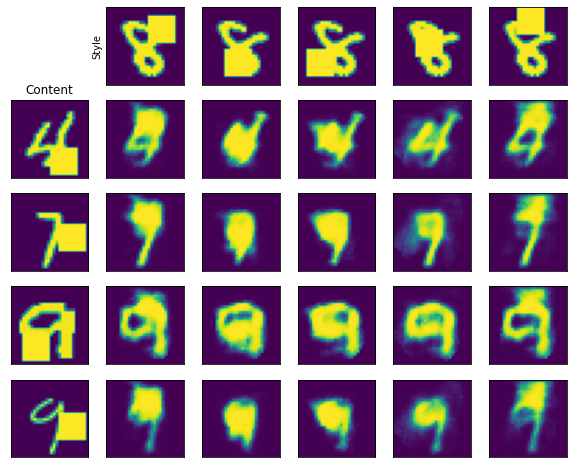

	mean loss    = 768.974
epoch = 46.81s
Start of epoch 26
	mean loss    = 764.391
epoch = 44.84s
Start of epoch 27
	mean loss    = 761.318
epoch = 44.19s
Start of epoch 28
	mean loss    = 756.227
epoch = 44.45s
Start of epoch 29
	mean loss    = 752.326
epoch = 45.20s
Start of epoch 30
=== TRN ===


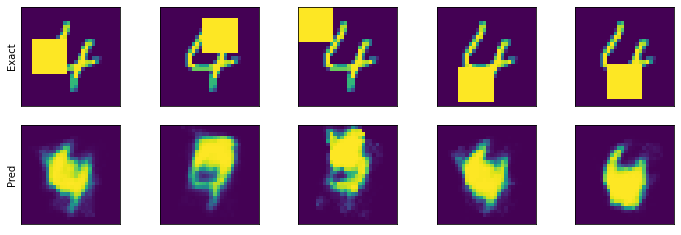

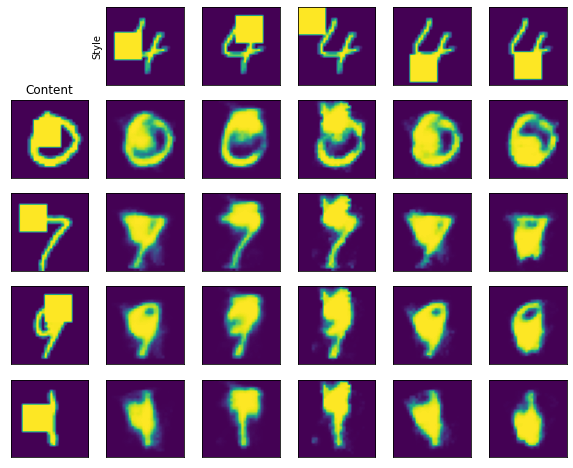

	mean loss    = 748.626
epoch = 46.41s
Start of epoch 31
	mean loss    = 745.422
epoch = 44.17s
Start of epoch 32
	mean loss    = 741.215
epoch = 43.87s
Start of epoch 33
	mean loss    = 737.950
epoch = 44.57s
Start of epoch 34
	mean loss    = 733.827
epoch = 43.85s
Start of epoch 35
=== TRN ===


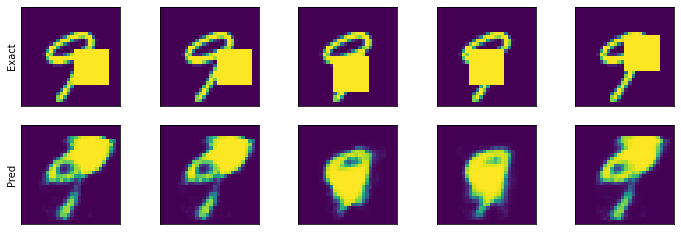

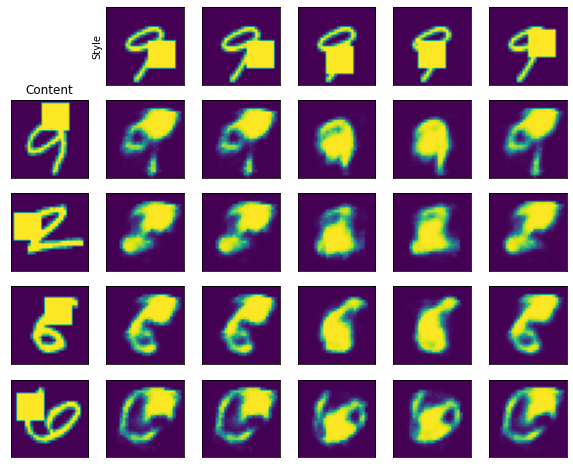

	mean loss    = 731.854
epoch = 46.14s
Start of epoch 36
	mean loss    = 728.077
epoch = 44.42s
Start of epoch 37
	mean loss    = 725.590
epoch = 43.50s
Start of epoch 38
	mean loss    = 722.250
epoch = 44.08s
Start of epoch 39
	mean loss    = 719.198
epoch = 43.70s
Start of epoch 40
=== TRN ===


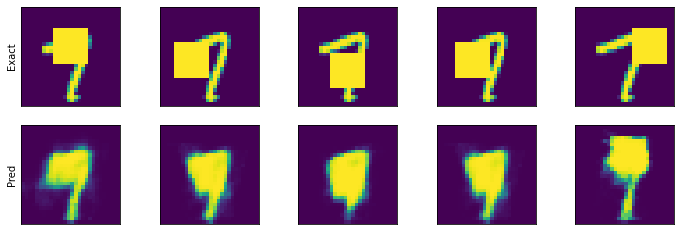

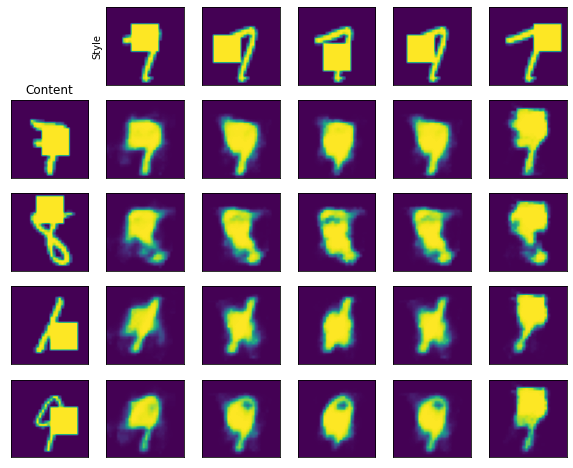

	mean loss    = 716.906
epoch = 46.12s
Start of epoch 41
	mean loss    = 713.789
epoch = 44.22s
Start of epoch 42
	mean loss    = 710.633
epoch = 44.01s
Start of epoch 43
	mean loss    = 709.503
epoch = 46.13s
Start of epoch 44
	mean loss    = 707.277
epoch = 44.40s
Start of epoch 45
=== TRN ===


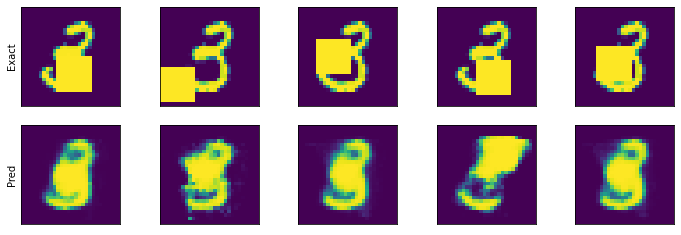

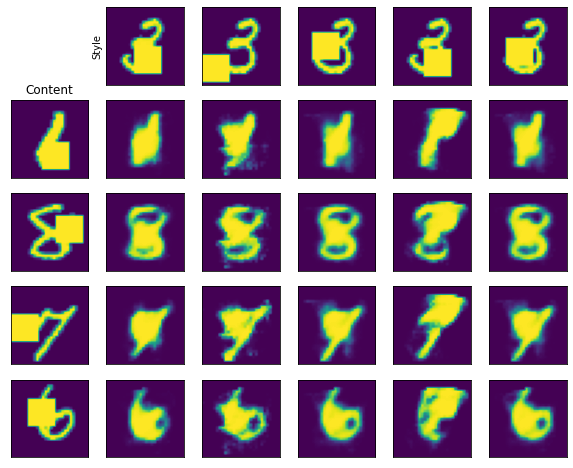

	mean loss    = 704.882
epoch = 47.05s
Start of epoch 46
	mean loss    = 702.580
epoch = 42.42s
Start of epoch 47
	mean loss    = 699.665
epoch = 44.33s
Start of epoch 48
	mean loss    = 698.105
epoch = 44.87s
Start of epoch 49
	mean loss    = 695.932
epoch = 43.81s
Start of epoch 50
=== TRN ===


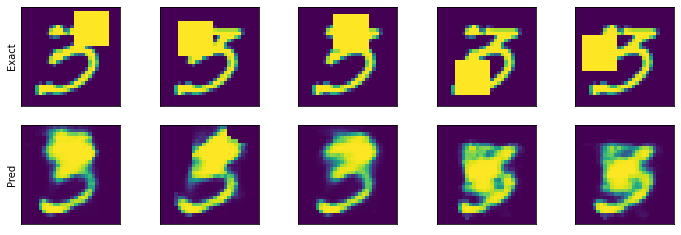

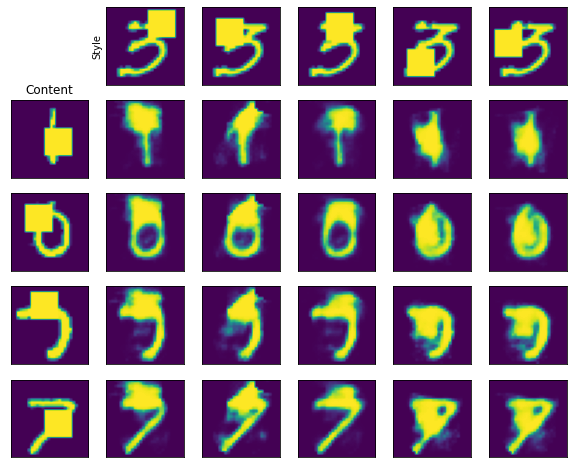

	mean loss    = 694.804
epoch = 45.87s
Start of epoch 51
	mean loss    = 691.928
epoch = 44.41s
Start of epoch 52
	mean loss    = 689.628
epoch = 43.91s
Start of epoch 53
	mean loss    = 687.590
epoch = 44.94s
Start of epoch 54
	mean loss    = 686.717
epoch = 44.06s
Start of epoch 55
=== TRN ===


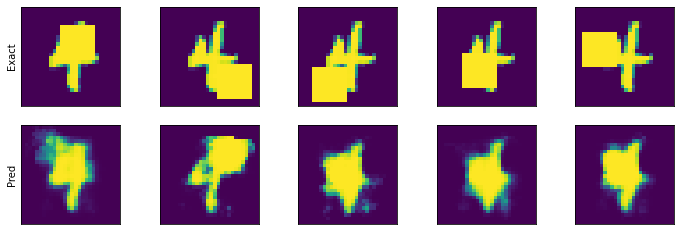

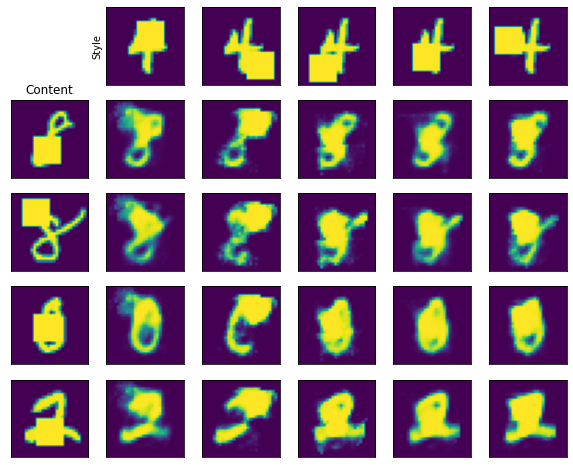

	mean loss    = 685.086
epoch = 46.68s
Start of epoch 56
	mean loss    = 682.788
epoch = 45.49s
Start of epoch 57
	mean loss    = 681.564
epoch = 45.42s
Start of epoch 58
	mean loss    = 679.523
epoch = 44.41s
Start of epoch 59
	mean loss    = 678.194
epoch = 44.42s
Start of epoch 60
=== TRN ===


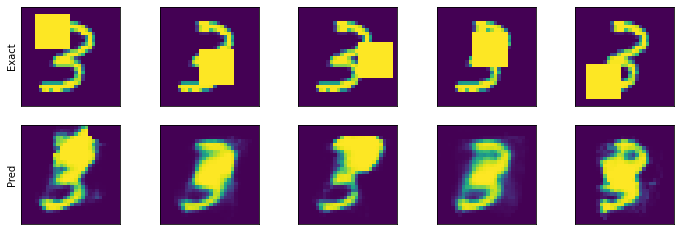

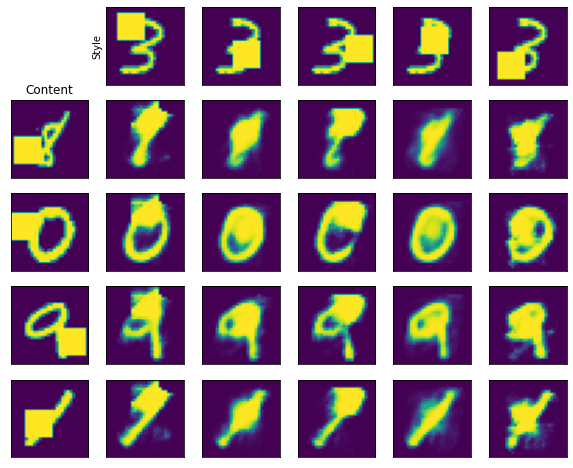

	mean loss    = 676.544
epoch = 47.71s
Start of epoch 61
	mean loss    = 675.700
epoch = 44.93s
Start of epoch 62
	mean loss    = 674.275
epoch = 44.01s
Start of epoch 63
	mean loss    = 671.792
epoch = 43.91s
Start of epoch 64
	mean loss    = 670.540
epoch = 43.00s
Start of epoch 65
=== TRN ===


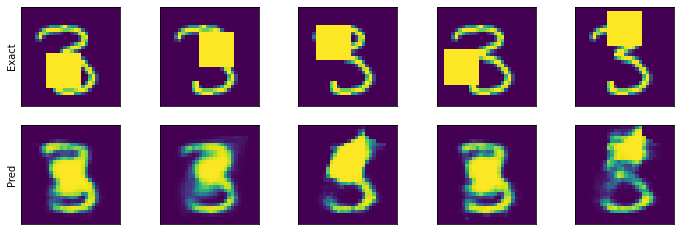

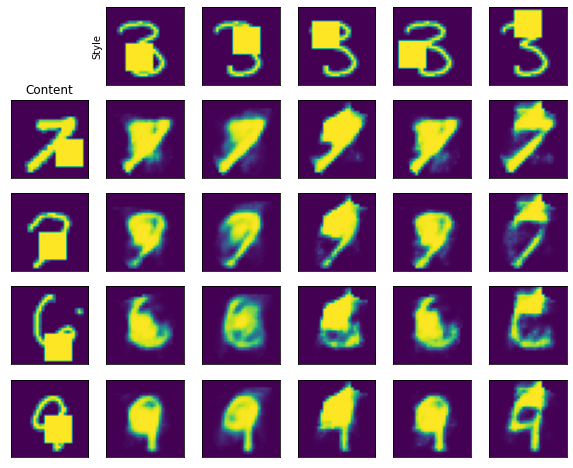

	mean loss    = 669.043
epoch = 47.19s
Start of epoch 66
	mean loss    = 668.426
epoch = 44.31s
Start of epoch 67
	mean loss    = 667.233
epoch = 43.98s
Start of epoch 68
	mean loss    = 664.973
epoch = 43.23s
Start of epoch 69
	mean loss    = 663.237
epoch = 44.32s
Start of epoch 70
=== TRN ===


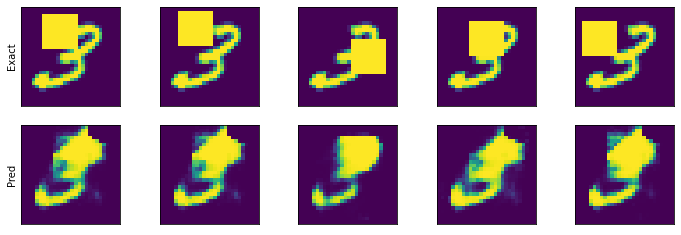

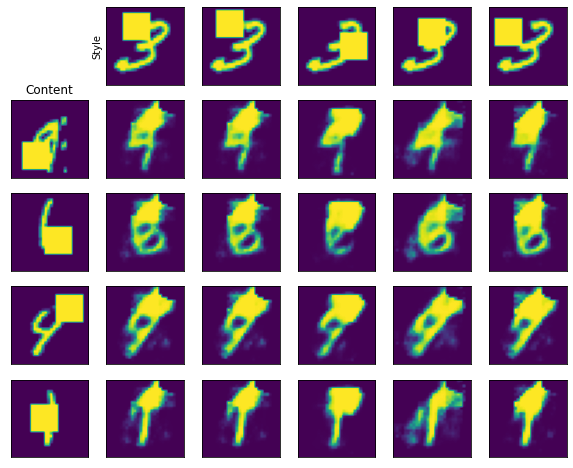

	mean loss    = 663.148
epoch = 45.75s
Start of epoch 71
	mean loss    = 661.439
epoch = 44.99s
Start of epoch 72
	mean loss    = 660.699
epoch = 44.33s
Start of epoch 73
	mean loss    = 659.315
epoch = 45.37s
Start of epoch 74
	mean loss    = 656.373
epoch = 45.33s
Start of epoch 75
=== TRN ===


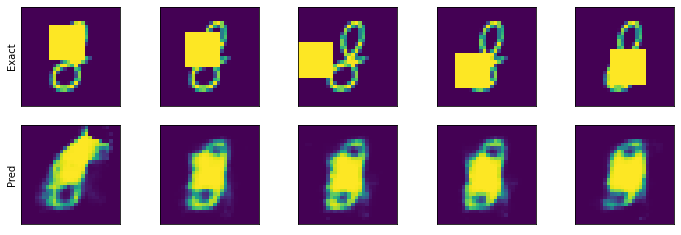

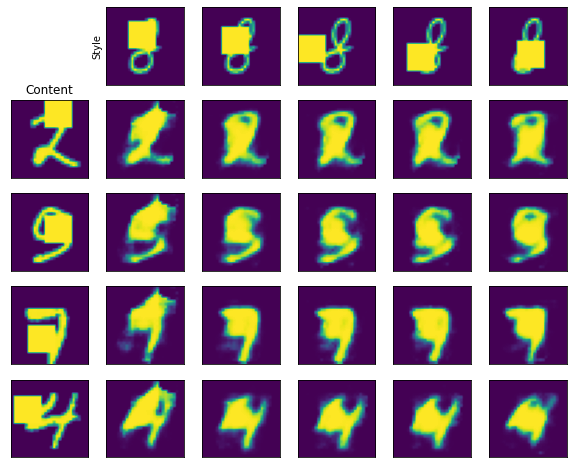

	mean loss    = 657.112
epoch = 47.13s
Start of epoch 76
	mean loss    = 655.817
epoch = 45.52s
Start of epoch 77
	mean loss    = 653.561
epoch = 45.18s
Start of epoch 78
	mean loss    = 653.176
epoch = 45.87s
Start of epoch 79
	mean loss    = 652.120
epoch = 44.83s
Start of epoch 80
=== TRN ===


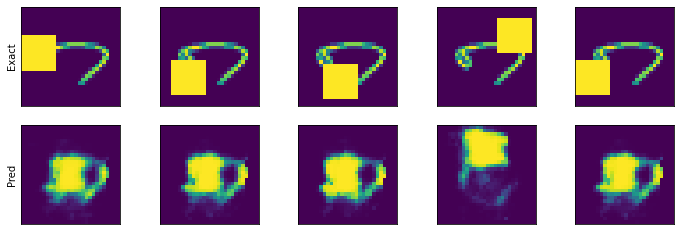

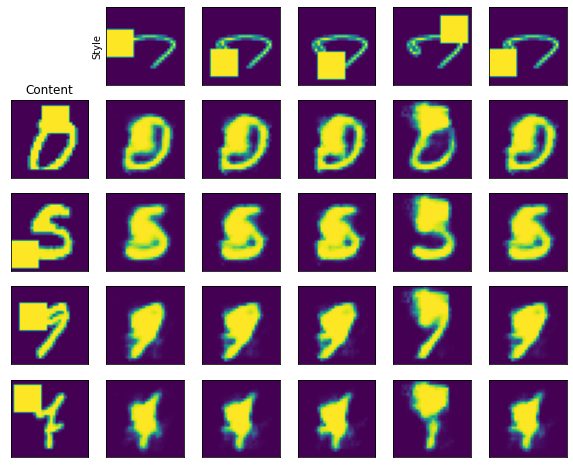

	mean loss    = 650.362
epoch = 47.38s
Start of epoch 81
	mean loss    = 649.778
epoch = 45.85s
Start of epoch 82
	mean loss    = 648.239
epoch = 44.77s
Start of epoch 83
	mean loss    = 647.210
epoch = 45.00s
Start of epoch 84
	mean loss    = 646.573
epoch = 44.13s
Start of epoch 85
=== TRN ===


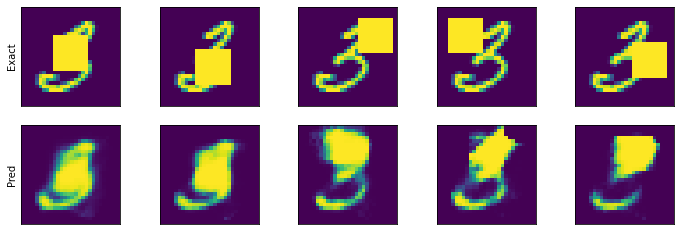

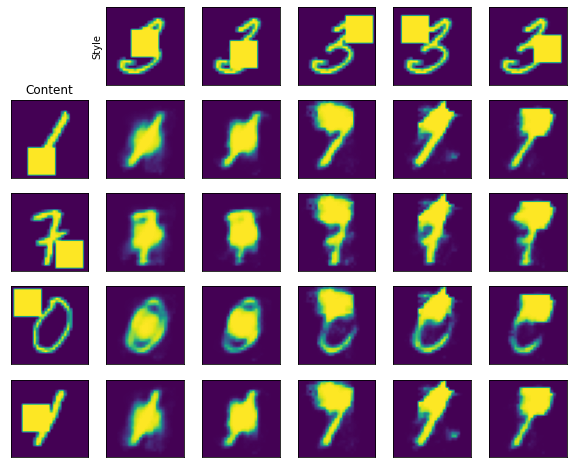

	mean loss    = 645.690
epoch = 45.34s
Start of epoch 86
	mean loss    = 644.628
epoch = 44.27s
Start of epoch 87
	mean loss    = 643.391
epoch = 44.55s
Start of epoch 88
	mean loss    = 643.551
epoch = 44.58s
Start of epoch 89
	mean loss    = 641.879
epoch = 44.29s
Start of epoch 90
=== TRN ===


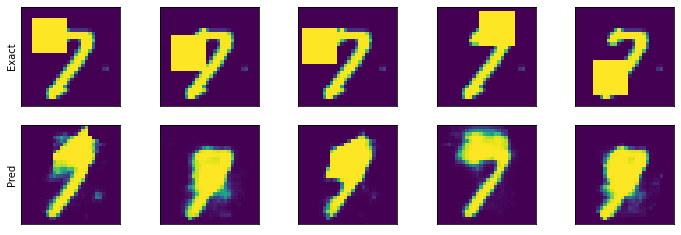

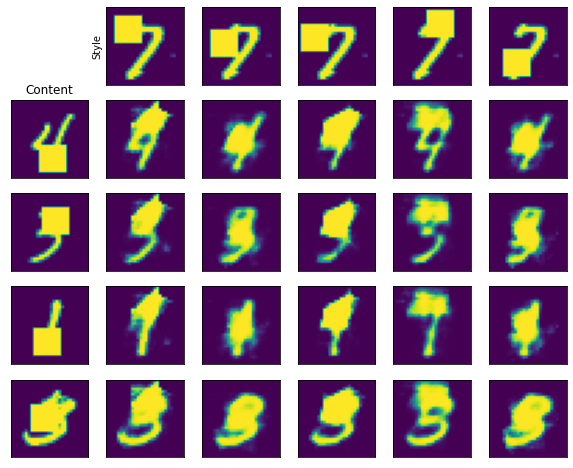

	mean loss    = 640.723
epoch = 45.81s
Start of epoch 91
	mean loss    = 640.479
epoch = 42.99s
Start of epoch 92
	mean loss    = 639.177
epoch = 44.43s
Start of epoch 93
	mean loss    = 638.729
epoch = 44.53s
Start of epoch 94
	mean loss    = 636.608
epoch = 44.18s
Start of epoch 95
=== TRN ===


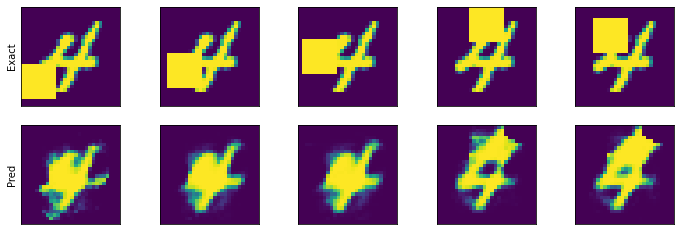

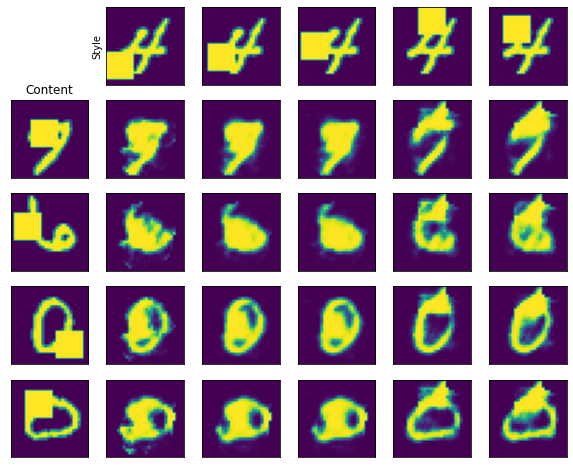

	mean loss    = 636.252
epoch = 46.47s
Start of epoch 96
	mean loss    = 635.769
epoch = 43.92s
Start of epoch 97
	mean loss    = 635.663
epoch = 44.99s
Start of epoch 98
	mean loss    = 633.625
epoch = 44.75s
Start of epoch 99
	mean loss    = 633.639
epoch = 45.04s
Start of epoch 100
=== TRN ===


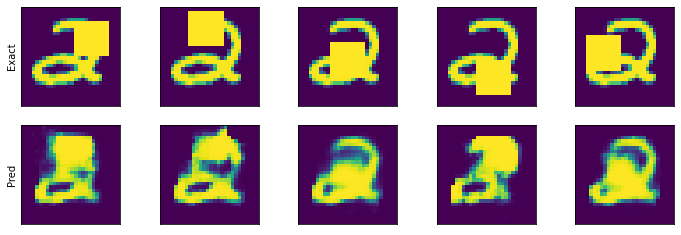

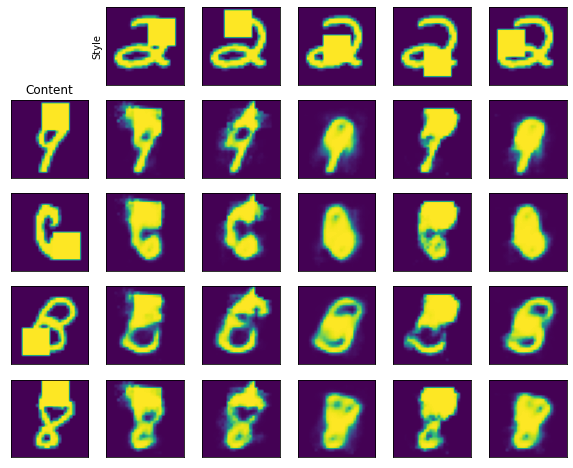

	mean loss    = 633.019
epoch = 47.61s


In [7]:
# Iterate over epochs.
num_epochs = 101

for epoch in range(num_epochs):
#     display.clear_output(wait=False)
    print('===================', flush=True)
    print('Start of epoch %d' % (epoch,))
    start_time = time.perf_counter()
         
    for step, trn_batch in enumerate(trn_dist_dataset):
        _ = distributed_train_step(trn_batch)
            
    if epoch % 5 == 0:
        print('=== TRN ===')
#         if strategy.num_replicas_in_sync > 1:
#             # grab only batch assigned to first GPU
#             trn_batch = [x.values[0].numpy() for x in trn_batch]
#         else:
#             trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = trn_batch.numpy()

        trn_batch = trn_batch.values[0].numpy()
    
        """ plot decoding of replicates """
        pred = symae.encode_decode(trn_batch)
#         se = (pred - trn_batch[0])**2 # squared error
        
        pred = pred.numpy()
        
        plt.figure(figsize=(12,4), facecolor='w')
        num_instance_plot = min([5, NUM_INSTANCES])
        for kk in np.arange(num_instance_plot):
            plt.subplot(2, num_instance_plot, kk+1)
            plt.imshow(trn_batch[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Exact')
                    
            plt.subplot(2, num_instance_plot, num_instance_plot+kk+1)
            plt.imshow(pred[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Pred')
            
        plt.show()
        
        """ plot styling of replicates """
        nsplot = 5 # number of style plots

        content_code = symae.content_encode(trn_batch).numpy()
        style_code = symae.style_encode(trn_batch).numpy()
        
        plt.figure(figsize=(10,10), facecolor='w')
        for jj in np.arange(nsplot):
            styled_mean = symae.style_decode(content_code[[jj],:,:], style_code[[0],:,:])
            styled_mean = styled_mean.numpy()
            for kk in np.arange(nsplot):
                if jj == 0:
                    # plot the style of each instance inside the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, kk+2)
                    plt.imshow(trn_batch[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    if kk==0:
                        plt.ylabel('Style')
                else:
                    if kk==0:
                        # plot an instance to show the "content"
                        plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+1)
                        plt.imshow(trn_batch[jj,0,:].reshape(28,28))
                        plt.xticks([]); plt.yticks([]);
                        if jj == 1:
                            plt.title('Content')

                    # style the jth bag with styles from the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+2)
                    plt.imshow(styled_mean[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    
        plt.show()
                
    print('\tmean loss    = %.3f' % trn_loss_metric.result().numpy())
    trn_loss_metric.reset_states()
    
    print('epoch = %.2fs' % (time.perf_counter()-start_time))

In [8]:
# # https://www.tensorflow.org/guide/keras/save_and_serialize#hdf5_format
# symae.save_weights('symae-masked-mnist.h5')